In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import pandas as pd
import scipy.io as sio
import glob
import cv2
from sklearn import svm
from scipy import signal
from skimage.filters import threshold_otsu
from matplotlib.patches import Circle
from sklearn.cluster import KMeans
from scipy import stats

In [ ]:
!wget https://raw.githubusercontent.com/LxMera/proyectos_investigacion/main/diabetes.py
!pip install tensorflow-io
!pip install tensorflow-addons

--2021-12-28 11:57:29--  https://raw.githubusercontent.com/LxMera/proyectos_investigacion/main/diabetes.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2018 (2.0K) [text/plain]
Saving to: ‘diabetes.py’

diabetes.py         100%[===================>]   1.97K  --.-KB/s    in 0s      

2021-12-28 11:57:30 (46.0 MB/s) - ‘diabetes.py’ saved [2018/2018]

     |████████████████████████████████| 23.1 MB 561 kB/s 
     |████████████████████████████████| 2.1 MB 54.9 MB/s 
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.22.0
    Uninstalling tensorflow-io-gcs-filesystem-0.22.0:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.22.0
     |████████████████████████████████| 1.1 MB 5.2 MB/s

In [ ]:
import tensorflow_io as tfio
import tensorflow_addons as tfa
import diabetes as dia

In [ ]:
data=sio.loadmat('/content/drive/MyDrive/AumentoThermo/Datasets/ima_distor.mat')

In [ ]:
images=data['images']
images=((images-np.min(images))/(np.max(images)-np.min(images))).astype('float32')
labels=data['labels'][0]
np.shape(images), np.shape(labels)

((6695, 128, 128, 3), (6695,))

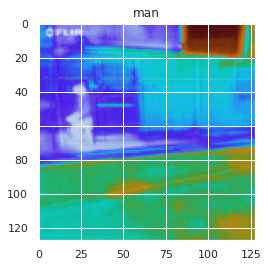

In [ ]:
Class=['man', 'cat', 'car']
sx=np.shape(labels)[0]
ind=np.random.choice(sx)
plt.title(Class[labels[ind]])
plt.imshow(images[ind])

In [ ]:
from tensorflow.keras import applications as ap
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow.compat.v1.keras.backend as K
import os
import math
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
import time
from IPython.display import clear_output

In [ ]:
def get_model(network, opt='adadelta', loss_name='categorical_crossentropy', input_shape=(128,128,3), classes=3, weights='imagenet'):
  try:
    del model
  except:
    print('done')
  model=Sequential()
  if network=='ResNet50V2':
    model.add(ap.ResNet50V2(include_top=False, weights=weights, input_shape=input_shape, pooling='avg', classes=classes)) # The input must have 3 channels
  if network=='EfficientNetB7':
    model.add(ap.EfficientNetB7(include_top=False, weights=weights, input_shape=input_shape, pooling='avg', classes=classes)) 
  if network=='InceptionResNetV2':
    model.add(ap.InceptionResNetV2(include_top=False, weights=weights, input_shape=input_shape, pooling='avg', classes=classes)) 
  if network=='InceptionV3':
    model.add(ap.InceptionV3(include_top=False, weights=weights, input_shape=input_shape, pooling='avg', classes=classes)) 
  if network=='NASNetLarge':
    model.add(ap.NASNetLarge(include_top=False, weights=weights, input_shape=input_shape, pooling='avg', classes=classes))
  if network=='VGG19':
    model.add(ap.VGG19(include_top=False, weights=weights, input_shape=input_shape, pooling='avg', classes=classes)) 
  if network=='Xception':
    model.add(ap.Xception(include_top=False, weights=weights, input_shape=input_shape, pooling='avg', classes=classes))
  if network=='DenseNet121':
    model.add(ap.DenseNet121(include_top=False, weights=weights, input_shape=input_shape, pooling='avg', classes=classes))
  
  model.add(Dense(classes, activation='softmax'))
  model.compile(optimizer=opt, loss=loss_name, metrics=['acc', tf.keras.metrics.Recall(), tf.keras.metrics.FalsePositives()])
  return model

In [ ]:
path='/content/drive/MyDrive/AumentoThermo/Results/Augmento/referencia'

In [ ]:
cs=glob.glob(path+'/results_csv/*.csv')

In [ ]:
cero=pd.read_csv(cs[0])
cero=cero.drop(cero.columns[:np.where(cero.columns=='run_n')[0][0]], axis=1)

In [ ]:
df = pd.DataFrame(columns=cero.columns)
df.head()

,run_n,k_fold,network,optimizer,loss,epochs,total_parameters,time,transfer,augm,Class,TP,TN,FP,FN,result_mat


In [ ]:
for name_c in cs:
  csv=pd.read_csv(name_c)
  df=df.append(csv, ignore_index=True)

In [ ]:
TP=np.array(df.loc[:,'TP'])
TN=np.array(df.loc[:,'TN'])
FP=np.array(df.loc[:,'FP'])
FN=np.array(df.loc[:,'FN'])

In [ ]:
df['Accuracy']= (TP+TN)/(TP+TN+FP+FN)
df['F1_score'] = (2*TP)/(2*TP+FP+FN)
df['Sensitivity'] = TP/(TP+FN)
df['Specificity'] = TN/(TN+FP)
df['Precision'] = TP/(TP+FP)
df['mean_metrics']=(((TP+TN)/(TP+TN+FP+FN))+((2*TP)/(2*TP+FP+FN))+(TP/(TP+FN))+(TN/(TN+FP))+(TP/(TP+FP)))/5

In [ ]:
transf=df[["result_mat", "Accuracy", 'F1_score', 'Sensitivity', 'Specificity', 'Precision', 'mean_metrics']].sort_values(by=['mean_metrics'], ascending=False).iloc[0,:][0]

In [ ]:
wig=path+'/Weights/'+transf.replace('_r.mat','w.h5')

In [ ]:
def transfer_model(path_model, confirmation_of_weights=True):
  model=get_model('ResNet50V2',weights=None)
  model.load_weights(path_model)
  y_hat=model.predict(images)
  hat=np.argmax(y_hat, axis=1)
  print('Accuracy\t:',np.mean(labels==hat))
  new_model=get_model('ResNet50V2',input_shape=(199,88,3), classes=2, weights=None)
  new_model.layers[0].set_weights(model.layers[0].get_weights())

  if confirmation_of_weights:
    w1=new_model.layers[0]
    w2=model.layers[0]
    ind=np.random.choice(269)
    print(w1.weights[ind]==w2.weights[ind])
  return new_model

In [ ]:
modelo=transfer_model(wig)

done
Accuracy	: 0.9952203136669157
done
tf.Tensor([ True  True  True ...  True  True  True], shape=(1024,), dtype=bool)


In [ ]:
root='/content/drive/MyDrive/TrainModels/'
info=pd.read_csv(root+'ThermoDataBase.csv')
infA=sio.loadmat(root+'infoadd.mat')
info.head()

,Subject,Gender,Age,Weight,Heigh,IMC,General_R,LCA_R,LPA_R,MCA_R,MPA_R,TCI_R,General_L,LCA_L,LPA_L,MCA_L,MPA_L,TCI_L
0,DM001,M,55.0,82.0,1.66,29.76,32.47,32.08,32.70,32.36,32.79,6.48,32.09,31.53,32.39,31.81,32.39,6.03
1,DM002,M,60.0,90.0,1.71,30.78,26.99,26.54,26.95,26.84,27.38,0.93,26.33,26.39,25.93,26.75,26.45,0.38
2,DM003,F,66.0,NaN,NaN,NaN,28.04,28.22,27.57,29.06,27.70,2.14,27.19,26.96,26.96,27.90,27.38,1.30
3,DM004,M,57.0,NaN,NaN,NaN,32.32,31.67,32.54,31.86,32.61,6.17,30.71,29.78,30.96,31.04,30.72,4.62
4,DM005,M,40.0,NaN,NaN,NaN,24.48,24.19,24.48,24.26,24.52,1.64,25.36,24.40,25.72,24.88,25.57,0.87


In [ ]:
data_0=sio.loadmat(root+'DM_Data.mat')

In [ ]:
temp=data_0['Temp']
angi=data_0['Angiosoms']
Subj=data_0['Subject']
labe=data_0['Type'][0]
Gend=data_0['Gender']
Late=data_0['Laterality']
sizx=np.shape(temp)
maxi=np.max(temp)
mini=np.min(temp[temp!=0])

In [ ]:
normt=(temp-mini)/(maxi-mini)
normt[normt<0]=0
for i in range(np.shape(normt)[0]):
  if Late[i]=='L':
    normt[i]=np.flip(normt[i], axis=1)

Índice : 294


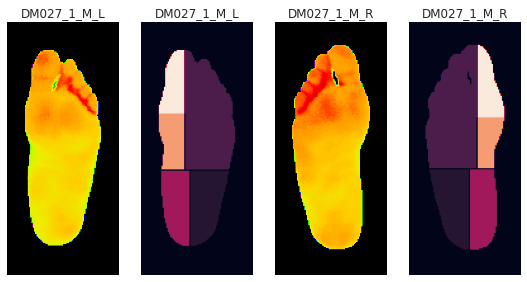

In [ ]:
dia.random_plot(sizx, Subj, labe, Gend, Late, maxi, mini, temp, angi)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.decomposition import DictionaryLearning, FactorAnalysis, FastICA
from sklearn.decomposition import IncrementalPCA
from scipy import sparse
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF

In [ ]:
def noise(x,y,per=0.1):
  if per<0.001:
    rand2=np.ones((x,y))
    return rand2
  if per>1:
    rand2=np.random.rand(x,y)
    return rand2
  per=1-per
  rand=np.random.rand(x,y)
  frac=(per)/(np.max(rand)-per)
  rand2=rand+frac
  rand2=rand2/np.max(rand2)
  return rand2

In [ ]:
def plot3(one, two, thr, four, name=''):
  plt.figure(figsize=(14,7))
  plt.subplot(1,4,1)
  plt.imshow(one, cmap='nipy_spectral')
  plt.title('Original')
  plt.axis('off')
  plt.subplot(1,4,2)
  plt.imshow(two, cmap='nipy_spectral')
  plt.title('Noise=0.1')
  plt.axis('off')
  plt.subplot(1,4,3)
  plt.imshow(thr, cmap='nipy_spectral')
  plt.title('Noise=0.5')
  plt.axis('off')
  plt.subplot(1,4,4)
  plt.title('Noise=1.0')
  plt.imshow(four, cmap='nipy_spectral')
  plt.axis('off')
  plt.savefig(name+'.svg')

In [ ]:
def pca_images(data, percentage=1):
  sz1=np.shape(data)
  ncomp=sz1[0]
  flat=np.array(data).reshape(sz1[0],sz1[1]*sz1[2])

  pca = PCA(n_components=ncomp)
  pca.fit(flat)  
  space1=pca.transform(flat)  #Sujetos con número reducidos de caracterísicas
  
  x,y=np.shape(space1)  
  rand=noise(x,y,percentage)

  ima=space1*rand
  ima=pca.inverse_transform(ima)
  
  ima=(ima-np.min(ima))/(np.max(ima)-np.min(ima)).astype('float32')
  ima=ima.reshape(sz1[0],sz1[1],sz1[2])
  ima=ima*(data!=0)
  ref_max=np.max(np.max(data, axis=1), axis=1)/np.max(np.max(ima, axis=1), axis=1)
  out=((ima.T*ref_max).T).astype('float32')
  return out

In [ ]:
def NonNegative_Matrix_Factorization(data, percentage=1):
  sz1=np.shape(data)
  ncomp=sz1[0]
  flat=np.array(data).reshape(sz1[0],sz1[1]*sz1[2])

  modelo=NMF(n_components=ncomp, random_state=0)  
  space1= modelo.fit_transform(flat)  #Sujetos con número reducidos de caracterísicas
  
  x,y=np.shape(space1)  
  rand=noise(x,y,percentage)

  ima=space1*rand
  ima=modelo.inverse_transform(ima)
  
  ima=(ima-np.min(ima))/(np.max(ima)-np.min(ima)).astype('float32')
  ima=ima.reshape(sz1[0],sz1[1],sz1[2])
  ima=ima*(data!=0)
  ref_max=np.max(np.max(data, axis=1), axis=1)/np.max(np.max(ima, axis=1), axis=1)
  out=((ima.T*ref_max).T).astype('float32')
  return out

In [ ]:
def Kernel_PCA(data, percentage=1):
  sz1=np.shape(data)
  ncomp=sz1[0]
  flat=np.array(data).reshape(sz1[0],sz1[1]*sz1[2])

  kern = KernelPCA(n_components=ncomp, kernel='linear', fit_inverse_transform=True) 
  space1=kern.fit_transform(flat)  #Sujetos con número reducidos de caracterísicas
  
  x,y=np.shape(space1)  
  rand=noise(x,y,percentage)

  ima=space1*rand
  ima=kern.inverse_transform(ima)
  
  ima=(ima-np.min(ima))/(np.max(ima)-np.min(ima)).astype('float32')
  ima=ima.reshape(sz1[0],sz1[1],sz1[2])
  ima=ima*(data!=0)
  ref_max=np.max(np.max(data, axis=1), axis=1)/np.max(np.max(ima, axis=1), axis=1)
  out=((ima.T*ref_max).T).astype('float32')
  return out

In [ ]:
def Incremental_PCA(data, percentage=0.1):
  sz1=np.shape(data)
  ncomp=sz1[0]
  flat=np.array(data).reshape(sz1[0],sz1[1]*sz1[2])

  InPCA = IncrementalPCA(n_components=ncomp, batch_size=200)
  X_sparse = sparse.csr_matrix(flat)  
  space1 = InPCA.fit_transform(X_sparse)  #Sujetos con número reducidos de caracterísicas
  
  x,y=np.shape(space1)  
  rand=noise(x,y,percentage)

  ima=space1*rand
  ima=InPCA.inverse_transform(ima)
  
  ima=(ima-np.min(ima))/(np.max(ima)-np.min(ima)).astype('float32')
  ima=ima.reshape(sz1[0],sz1[1],sz1[2])
  ima=ima*(data!=0)
  ref_max=np.max(np.max(data, axis=1), axis=1)/np.max(np.max(ima, axis=1), axis=1)
  out=((ima.T*ref_max).T).astype('float32')
  return out

In [ ]:
def factor_analysis(data, percentage=0.1):
  sz1=np.shape(data)
  ncomp=sz1[0]
  flat=np.array(data).reshape(sz1[0],sz1[1]*sz1[2])


  FA = FactorAnalysis(n_components=ncomp, random_state=0)
  space1=FA.fit_transform(flat)  #Sujetos con número reducidos de caracterísicas
  
  x,y=np.shape(space1)  
  rand=noise(x,y,percentage)

  ima=space1*rand
  ima=ima@FA.components_
  
  ima=(ima-np.min(ima))/(np.max(ima)-np.min(ima)).astype('float32')
  ima=ima.reshape(sz1[0],sz1[1],sz1[2])
  ima=ima*(data!=0)
  ref_max=np.max(np.max(data, axis=1), axis=1)/np.max(np.max(ima, axis=1), axis=1)
  out=((ima.T*ref_max).T).astype('float32')
  return out

In [ ]:
def Independent_component_Analysis(data, percentage=0.1):
  sz1=np.shape(data)
  ncomp=sz1[0]
  flat=np.array(data).reshape(sz1[0],sz1[1]*sz1[2])

  ICA = FastICA(n_components=20, random_state=0)
  space1 = ICA.fit_transform(flat)
    
  x,y=np.shape(space1)  
  rand=noise(x,y,percentage)

  ima=space1*rand
  ima=ima@ICA.components_
  
  ima=(ima-np.min(ima))/(np.max(ima)-np.min(ima)).astype('float32')
  ima=ima.reshape(sz1[0],sz1[1],sz1[2])
  ima=ima*(data!=0)
  ref_max=np.max(np.max(data, axis=1), axis=1)/np.max(np.max(ima, axis=1), axis=1)
  out=((ima.T*ref_max).T).astype('float32')
  return out

In [ ]:
def Dictionary_Learning(data, percentage=0.1):
  sz1=np.shape(data)
  ncomp=sz1[0]
  flat=np.array(data).reshape(sz1[0],sz1[1]*sz1[2])

  dict_learner = DictionaryLearning(n_components=ncomp, transform_algorithm='lasso_lars', random_state=42)
  space1 = dict_learner.fit_transform(flat)
    
  x,y=np.shape(space1)  
  rand=noise(x,y,percentage)

  ima=space1*rand
  ima=ima@dict_learner.components_
  
  ima=(ima-np.min(ima))/(np.max(ima)-np.min(ima)).astype('float32')
  ima=ima.reshape(sz1[0],sz1[1],sz1[2])
  ima=ima*(data!=0)
  ref_max=np.max(np.max(data, axis=1), axis=1)/np.max(np.max(ima, axis=1), axis=1)
  out=((ima.T*ref_max).T).astype('float32')
  return out

In [ ]:
def Latent_Dirichlet_Allocation(data, percentage=0.1):
  sz1=np.shape(data)
  ncomp=sz1[0]
  flat=np.array(data).reshape(sz1[0],sz1[1]*sz1[2])

  lda = LatentDirichletAllocation(n_components=ncomp, random_state=0)
  X_transformed = lda.fit(flat)
  space1=X_transformed.transform(flat)

  x,y=np.shape(space1)    
  rand=noise(x,y,percentage)

  ima=space1*rand
  ima=ima@X_transformed.components_
  
  ima=(ima-np.min(ima))/(np.max(ima)-np.min(ima)).astype('float32')
  ima=ima.reshape(sz1[0],sz1[1],sz1[2])
  ima=ima*(data!=0)
  ref_max=np.max(np.max(data, axis=1), axis=1)/np.max(np.max(ima, axis=1), axis=1)
  out=((ima.T*ref_max).T).astype('float32')
  return out

In [ ]:
def without_aug(data, percentage=0):
  return data

In [ ]:
def flip_v(data, value):
  out=tf.image.flip_up_down(data.reshape(*np.shape(data),1))
  out=out[...,0]
  return out

In [ ]:
def flip_h(data, value):
  out=tf.image.flip_left_right(data.reshape(*np.shape(data),1))
  out=out[...,0]
  return out

In [ ]:
def color_space(data, value):
  data=data.reshape((*np.shape(data),1))
  data=tf.image.grayscale_to_rgb(tf.convert_to_tensor(data))
  space1=tfio.experimental.color.rgb_to_ycbcr(np.array(data*255/np.max(data)).astype('uint8'))
  space1=tfio.experimental.color.rgb_to_hsv((np.array(space1)/np.max(space1)).astype('float32'))
  out=np.concatenate((data, space1))  
  return out

In [ ]:
def gaussian_filter(data, value):
  out=tfa.image.gaussian_filter2d(data.reshape(*np.shape(data),1), (3,3), sigma=90)
  out=out/np.max(out)
  out=out[...,0]
  return out

In [ ]:
methods={'PCA': pca_images,
         'DL': Dictionary_Learning,
         'FA': factor_analysis,
         'ICA':Independent_component_Analysis,
         'InPCA': Incremental_PCA,
         'kPCA': Kernel_PCA,
         'LDA': Latent_Dirichlet_Allocation,
         'NNMF':NonNegative_Matrix_Factorization,
         'Color': color_space,
         'Gaussian': gaussian_filter,
         'Horizontal_f':flip_h,
         'Vertical_f':flip_v,
         'None': without_aug}

In [ ]:
def draw_augmentation(data, method='PCA', subjects='CG', noise_p=1):
  if subjects=='CG':
    datf=data[:90]
    ind=np.random.choice(90)
  else:
    datf=data[90:]
    ind=90+np.random.choice(122)
  plt.subplot(1,2,1)
  plt.imshow(data[ind], cmap='nipy_spectral', vmin=0, vmax=1)
  plt.title(subjects+' ID: '+str(ind))
  plt.grid()
  plt.colorbar()
  plt.subplot(1,2,2)
  aum=methods[method](datf, noise_p)
  plt.imshow(aum[ind], cmap='nipy_spectral', vmin=0, vmax=1)
  plt.title(method)
  plt.grid()
  plt.colorbar()
  return aum

In [ ]:
def get_index(data, run, k_fold=5):
  tm=np.shape(data)[0]
  anch=int(tm/k_fold)
  fold=run%k_fold
  np.random.seed(2000)
  ind=np.random.choice(tm,tm, replace=False)
  i_test=ind[fold*anch:(fold+1)*anch]
  i_train=np.delete(ind, np.arange(fold*anch,(fold+1)*anch))
  return i_train, i_test

In [ ]:
dfx = pd.DataFrame(columns=('run_n', 'k_fold', 'network', 'optimizer', 'loss', 'epochs', 'total_parameters', 'time', 'time_aug', 'transfer', 'augm', 'Class', 'TP', 'TN', 'FP', 'FN','result_mat'))
dfx.head()

,run_n,k_fold,network,optimizer,loss,epochs,total_parameters,time,time_aug,transfer,augm,Class,TP,TN,FP,FN,result_mat


In [ ]:
import tensorflow.compat.v1.keras.backend as K
import os
import math
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
import time
from IPython.display import clear_output

In [ ]:
TPx=tf.keras.metrics.TruePositives()
TNx=tf.keras.metrics.TrueNegatives()
FPx=tf.keras.metrics.FalsePositives()
FNx=tf.keras.metrics.FalseNegatives()

In [ ]:
def one_hot(vec):
  items=np.sort(pd.unique(vec))
  n_class=np.shape(items)[0]
  resul=np.zeros((vec.size, n_class))
  for n,i in enumerate(items):
    rows=np.where(vec==i)[0]
    resul[rows,n]=1
  return resul.astype('float32')

In [ ]:
def rgb(data):
  data=data.reshape((*np.shape(data),1))
  data=tf.image.grayscale_to_rgb(tf.convert_to_tensor(data))
  return np.array(data)

In [ ]:
def data_augmentation_function(data, labels, method):
  tik = time.time() 
  if method=='Color':                 
    out=methods[method](data,0.5)
    lab=np.concatenate((labels, labels))

    sx=np.shape(out)[0]
    idx=np.random.choice(sx,sx,replace=False)
    out=out[idx]
    lab=lab[idx]

    tok=time.time()-tik
    return out, one_hot(lab), tok  
  else:            
    new=methods[method](data,0.5)
    out=np.concatenate((data, new))
    lab=np.concatenate((labels, labels))

    sx=np.shape(out)[0]
    idx=np.random.choice(sx,sx,replace=False)
    out=out[idx]
    lab=lab[idx]

    tok=time.time()-tik
    return rgb(out), one_hot(lab), tok

In [ ]:
def run_experiment(images, labels, number_class, data_augmentation, name='x', star_fold=0, star_run=0, end_run=6, batch_size=16):
  for augm_con in data_augmentation:
    for net in Networks:
      name_0='_'.join(['Thermo', name, str(transferlearning), augm_con, net, optimizer])
      if not os.path.exists(path2+name_0+'.csv'):
        dfx.to_csv(path2+name_0+'.csv')

      for n_fold in range(star_fold,5):
        train_id, test_id=get_index(labels, n_fold)

        x_test, y_test= rgb(images[test_id]), one_hot(labels[test_id])

        x_train,y_train=images[train_id], labels[train_id]
        x_aug, y_aug, tau=data_augmentation_function(x_train, y_train, augm_con)

        for i in range(star_run, end_run): #Numero corridas 
          for j in [loss]: #Funciones de perdida
            cntn=True
            name_m='_'.join([name_0,j,'run',str(i),'fold',str(n_fold)])  
            print(name_m)

            #Obtener imagenes nuevamente
            model=transfer_model(wig)

            try:
              tic = time.time()
              results = model.fit(x_aug, y_aug, batch_size=batch_size, epochs=epochs)
              toc=time.time()-tic
              model.save_weights(pathW+name_m+"w.h5")
            except:
              print('Training error')
              cntn=False

            if cntn:
              sio.savemat(pathW+name_m+'_r.mat', results.history)

              #Validation
              y_hat=np.array(model.predict(x_test))
              sio.savemat(pathW+name_m+'_los_8.mat',{'y_hat': y_hat, 'y_test': np.array(y_test)})
              #y_hat=y_hat>=0.5

              for class_i in range(number_class):
                TPx.reset_state()
                TNx.reset_state()
                FPx.reset_state()
                FNx.reset_state()        

                TPx.update_state(y_test[:,class_i], y_hat[:,class_i])
                TNx.update_state(y_test[:,class_i], y_hat[:,class_i])
                FPx.update_state(y_test[:,class_i], y_hat[:,class_i])
                FNx.update_state(y_test[:,class_i], y_hat[:,class_i])
                total_p=model.count_params()

                #data frame
                df2=pd.read_csv(path2+name_0+'.csv')
                df2=df2.append({'run_n': i,
                                'k_fold': n_fold,
                                'network': net,
                                'optimizer': optimizer,
                                'loss': 'categorical_crossentropy',
                                'epochs': epochs,
                                'total_parameters': total_p,
                                'time': toc,
                                'time_aug': tau,
                                'transfer': transferlearning,
                                'augm': augm_con,
                                'Class': class_i,
                                'TP': float(TPx.result()),
                                'TN': float(TNx.result()),
                                'FP': float(FPx.result()),
                                'FN': float(FNx.result()),
                                'result_mat': name_m+'_r.mat'} , ignore_index=True)
                df2=df2.drop(df2.columns[:np.where(df2.columns=='run_n')[0][0]], axis=1)
                df2.to_csv(path2+name_0+'.csv')
              del model #x_train, y_train,
              clear_output(wait=True)
        star_run=0
      star_fold=0

In [ ]:
root2='/content/drive/MyDrive/AumentoThermo'

Networks=['ResNet50V2']#, 'InceptionV3', 'DenseNet121', 'Xception', 'VGG19', 'InceptionResNetV2', 'EfficientNetB7']
path2=root2+'/Results/Augmento/termotransfer/results_csv/'
pathW=root2+'/Results/Augmento/termotransfer/Weights/'

augmentation=['Color', 'Gaussian', 'Horizontal_f', 'Vertical_f', 'None']
transferlearning='imagenet'
optimizer='adadelta'
epochs=50
loss='categorical_crossentropy'

#----------------------------------RUN------------------------------------------
run_experiment(normt, labe, 2, augmentation, star_fold=3, star_run=0)

Thermo_x_imagenet_None_ResNet50V2_adadelta_categorical_crossentropy_run_5_fold_4
done
Accuracy	: 0.9952203136669157
done
tf.Tensor(
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  Tru